In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os


from hksimulation.Simulation_Branch_HP import Simulation_Branch_HP
from hksimulation.Simulation_Thinning_Poisson import Simulation_Thinning_Poisson
from hksimulation.ImpactFunction import ImpactFunction 
# from .Kernel import Kernel

# from Initialization_Cluster_Basis import Initialization_Cluster_Basis

# from Learning_Cluster_Basis import Learning_Cluster_Basis

# from Estimate_Weight import Estimate_Weight

In [3]:
#1. 参数设置



options = {
    'N': 100, 'Nmax': 100, 'Tmax': 50, 'tstep': 0.1,
    'dt': [0.1], 'M': 250, 'GenerationNum': 10
}

D = 3
K = 2
nTest = 5
nSeg = 5
nNum = options['N'] / nSeg


In [4]:
#2. 霍克斯过程的模拟（通过一个分支过程近似地模拟霍克斯过程）
# First cluster: Hawkes process with exponential kernel
print('Simple exponential kernel')
para1 = {'kernel': 'exp', 'landmark': [0]}
para1['mu'] = np.random.rand(D) / D
L = len(para1['landmark'])
para1['A'] = np.zeros((D, D, L))
for l in range(1, L + 1):
    para1['A'][:, :, l - 1] = (0.7**l) * np.random.rand(D,D)

#import pdb;pdb.set_trace()
# 对每个切片应用 np.linalg.eigh
eigvals_list = []
eigvecs_list = []
for l in range(L):
    eigvals, eigvecs = np.linalg.eigh(para1['A'][:, :, l])
    eigvals_list.append(eigvals)
    eigvecs_list.append(eigvecs)

# 对所有特征值进行处理
all_eigvals = np.concatenate(eigvals_list)
max_eigval = np.max(all_eigvals)
#import pdb;pdb.set_trace()
# 使用最大特征值进行归一化
para1['A'] = 0.5 * para1['A'] / max_eigval
para1['w'] = 0.5

Seqs1 = Simulation_Branch_HP(para1, options)


########################################################################################

# Second cluster: Hawkes process with Gaussian kernel
print('Complicated gaussian kernel')
para2 = {'kernel': 'gauss', 'landmark': np.arange(0, 13, 3)}
para2['mu'] = np.random.rand(D) / D
L = len(para2['landmark'])
para2['A'] = np.zeros((D, D, L))
for l in range(1, L + 1):
    para2['A'][:, :, l - 1] = (0.9**l) * np.random.rand(D,D)
para2['A'] = 0.25 * para2['A'] / np.max(np.abs(np.linalg.eigh(np.sum(para2['A'], axis=2))[0]))
para2['A'] = np.reshape(para2['A'], (D, L, D))
#import pdb;pdb.set_trace()
para2['w'] = 1
Seqs2 = Simulation_Branch_HP(para2, options)
SeqsMix = Seqs1 + Seqs2
#import pdb;pdb.set_trace()

# Ground truth: the similarity matrix of event sequences.
# GT[i, j] = 1 if the sequence i and the sequence j belong to the same cluster


GT = np.block([[np.ones((options['N'], options['N'])),  np.zeros((options['N'], options['N']))],
               [ np.zeros((options['N'], options['N'])), np.ones((options['N'], options['N']))]])

Simple exponential kernel
#seq=10/100, #event=67
#seq=20/100, #event=36
#seq=30/100, #event=100
#seq=40/100, #event=73
#seq=50/100, #event=64
#seq=60/100, #event=66
#seq=70/100, #event=23
#seq=80/100, #event=58
#seq=90/100, #event=93
#seq=100/100, #event=68
Complicated gaussian kernel
#seq=10/100, #event=12
#seq=20/100, #event=12
#seq=30/100, #event=6
#seq=40/100, #event=13
#seq=50/100, #event=9
#seq=60/100, #event=17
#seq=70/100, #event=14
#seq=80/100, #event=8
#seq=90/100, #event=18
#seq=100/100, #event=11


/data/dyw/mcmcbmm/hkstools/hksimulation/Kernel.py:31: RuntimeWarning: overflow encountered in square
  g = np.exp(-(distance**2) / (2 * para['w']**2)) / (np.sqrt(2 * np.pi) * para['w'])


In [5]:
import numpy as np
from scipy.sparse import csr_matrix
def Initialization_Cluster_Basis(Seqs, ClusterNum, baseType=None, bandwidth=None, landmark=None):
    # Seqs：输入的序列集合。
    # ClusterNum：聚类的数量。
    # baseType、bandwidth、landmark：这些是可选参数，用于定义模型中的不同特征和属性。
    N = len(Seqs)
    D = np.zeros(N)

    for i in range(N):
        D[i] = np.max(Seqs[i]['Mark'])
    
    D = int(np.max(D))+1
    model = {'K': ClusterNum, 'D': D}
    #如果只传入 Seqs 和 ClusterNum，则使用默认的高斯核，计算标准差和最大时间以初始化模型。
    if baseType is None and bandwidth is None and landmark is None:
        sigma = np.zeros(N)
        Tmax = np.zeros(N)

        for i in range(N):
            sigma[i] = ((4 * np.std(Seqs[i]['Time'])**5) / (3 * len(Seqs[i]['Time'])))**0.2
            Tmax[i] = Seqs[i]['Time'][-1] + np.finfo(float).eps
        Tmax = np.mean(Tmax)

        model['kernel'] = 'gauss'#核函数类型
        model['w'] = np.mean(sigma)#带宽
        model['landmark'] = model['w'] * np.arange(0, np.ceil(Tmax / model['w']))#地标
        
    #如果传入更多参数，模型将根据这些参数进行初始化
    # 当 baseType 被提供，但 bandwidth 和 landmark 未提供时
    elif baseType is not None and bandwidth is None and landmark is None:
        model['kernel'] = baseType
        model['w'] = 1
        model['landmark'] = 0
    # 当 baseType 和 bandwidth 被提供，但 landmark 未提供时
    elif baseType is not None and bandwidth is not None and landmark is None:
        model['kernel'] = baseType
        model['w'] = bandwidth
        model['landmark'] = 0
    # 当所有参数都被提供时，这是最灵活的情况，允许用户完全自定义模型的初始化
    else:
        model['kernel'] = baseType if baseType is not None else 'gauss'
        model['w'] = bandwidth if bandwidth is not None else 1
        model['landmark'] = landmark if landmark is not None else 0

    model['alpha'] = 1
    M = len(model['landmark'])
    model['beta'] = np.ones((D, M, model['K'], D)) / (M * D**2)

    model['b'] = np.ones((D, model['K'])) / D

    
    # Initialize label and responsibility randomly
    #   我的天这个去掉了不知对不对
    #label = np.ceil(model['K'] * np.random.rand(1, N)).astype(int)
    model['label']=np.array([1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0])#label
    label = model['label']
    model['R'] = csr_matrix((np.ones(N), (np.arange(N), label.flatten())), shape=(N, model['K'])).toarray()
    # print(f"Initialization_Cluster_Basis : {model['R']}")
    return model

In [6]:
# #3. 霍克斯过程的混合模型学习
# 初始化模型，并通过某种学习算法（由 alg 参数指定）来学习霍克斯过程的混合模型。
# 最后，计算得到一个估计的相似度矩阵 Est1。
model = Initialization_Cluster_Basis(SeqsMix, 2)
alg = {'outer': 8, 'rho': 0.1, 'inner': 1, 'thres': 1e-5, 'Tmax': []}#'inner': 5

In [7]:
import numpy as np
# from hksimulation.Kernel import Kernel
# from hksimulation.Kernel_Integration import Kernel_Integration
from scipy.special import psi
import time
from scipy.special import erf

#模拟霍克斯过程。“Branch”可能暗示了它使用了某种分支过程方法来模拟霍克斯过程。
def Kernel(dt, para):
    """
    Compute the value of the kernel function at different time points.
    
    Parameters:
    - dt: Time differences between current time and historical events.
    - para: Dictionary containing kernel parameters.
        - para['kernel']: Type of the kernel function ('exp' or 'gauss').
        - para['landmark']: Landmarks for the kernel function.
        - para['w']: Bandwidth parameter for the kernel function.
    
    Returns:
    - g: Computed values of the kernel function.
    """
    dt = np.array(dt).flatten()
    # Create a 2D array of landmarks
    landmarks = np.array(para['landmark'])[np.newaxis, :]
    # Tile dt to have the same number of columns as the number of landmarks
    dt_tiled = np.tile(dt[:, np.newaxis], (1, len(para['landmark'])))
    # Calculate the distance
    distance = dt_tiled - landmarks

    if para['kernel'] == 'exp':
        g = para['w'] * np.exp(-para['w'] * distance)
        g[g > 1] = 0

    elif para['kernel'] == 'gauss':
        g = np.exp(-(distance**2) / (2 * para['w']**2)) / (np.sqrt(2 * np.pi) * para['w'])

    else:
        print('Error: please assign a kernel function!')
    return g


def Kernel_Integration(dt, para):
    # 转换 dt 和 landmark 为 NumPy 数组，并计算距离
    dt = dt.flatten()

    distance = np.tile(dt[:, np.newaxis], (1, len(para['landmark']))) - np.tile(para['landmark'], (len(dt), 1))
    landmark = np.tile(para['landmark'], (len(dt), 1))

    # 根据核函数类型进行计算
    if para['kernel'] == 'exp':
        G = 1 - np.exp(-para['w'] * (distance - landmark))
        G[G < 0] = 0

    elif para['kernel'] == 'gauss':
        G = 0.5 * (erf(distance / (np.sqrt(2) * para['w'])) + erf(landmark / (np.sqrt(2) * para['w'])))

    else:
        print('Error: please assign a kernel function!')
        G = None

    return G

#基于变分推断的学习过程，用于混合霍克斯过程模型
def Learning_Cluster_Basis(Seqs, model, alg):
    NLL = np.zeros(alg['outer'])#初始化一个记录负对数似然（Negative Log-Likelihood, NLL）的数组
    tic = time.time()
    for o in range(1, alg['outer']+1):
        # M步骤：通过调用 Maximization_MixHP 函数，这一步骤旨在最大化模型参数，给定当前对隐变量的估计
        model, NLL[o-1] = Maximization_MixHP(Seqs, model, alg) #更新 μ 和 A  #model['beta'] ，model['b'] 
        # E步骤：通过调用 Expectation_MixHP 函数，这一步骤基于当前模型参数来更新对隐变量的估计
        model,q_pai = Expectation_MixHP(Seqs, model, alg)#更新 π—— 和责任矩阵 r nk  #model['R']
        q_Z=model['R']#计算每个数据点属于不同簇的责任model['R']来近似

    #将 NLL 数组存储在模型字典中并返回更新后的模型。
    model['NLL'] = NLL
    return model

def Maximization_MixHP(Seqs, model, alg):
    # given responsibility, calculate the expected number of sequences belonging
    # to the k-th cluster
    EX = model['R']
    # update parameters of Hawkes processes (mu_k, A_k), k=1,...,N
    # initialize
    A = model['beta']
    mu = np.sqrt(np.pi/2) * model['b']
    NLL = 0
    
    for in_ in range(alg['inner']):
        tmp1 = A.flatten() / model['beta'].flatten()
        tmp1[np.isnan(tmp1)] = 0
        tmp1[np.isinf(tmp1)] = 0
        
        tmp2 = mu.flatten()**2 / (2 * model['b'].flatten()**2)
        tmp2[np.isnan(tmp2)] = 0
        tmp2[np.isinf(tmp2)] = 0

        tmp3 = np.log(mu.flatten())
        tmp3[np.isnan(tmp3)] = 0
        tmp3[np.isinf(tmp3)] = 0

        NLL = np.sum(tmp1) + np.sum(tmp2) - np.sum(tmp3)
        

        MuA = 1.0 / (model['b']**2)
        MuA[np.isinf(MuA)] = 0
        MuB = 0
        MuC = -np.ones(model['b'].shape)

        AB = np.zeros(A.shape)
        AA = 1.0 / model['beta']
        AA[np.isinf(AA)] = 0
        # E-step: evaluate the responsibility using the current parameters
        for c, seq in enumerate(Seqs):
            Time = seq['Time']
            Event = seq['Mark'].astype(int)

            Tstart = seq['Start']
            # 找终止时间
            if 'Tmax' in alg and alg['Tmax'] is not None and alg['Tmax']:# 确保 alg['Tmax'] 不是空的，并且是一个数值
                Tstop = alg['Tmax']
                # 使用 np.less 来避免形状不匹配的问题
                valid_indices = np.less(Time, alg['Tmax'])
                Time = Time[valid_indices]
                Event = Event[valid_indices]
            else:
                Tstop = seq['Stop']
                
            N = len(Time)
            G = Kernel_Integration(Tstop - Time, model)

            TMPAA = np.zeros(A.shape)
            TMPAB = np.zeros(A.shape)
            TMPMuC = np.zeros(mu.shape)
            
            LL = 0
            
            for i in range(N):
                ui = Event[i]
                ti = Time[i]
                # 调整 np.tile 的使用以确保形状匹配
                G_expanded = np.tile(G[i][:, np.newaxis, np.newaxis], (1, model['D'], model['K'])).transpose(0, 2, 1)
                TMPAA[ui,:] += G_expanded     
                lambdai = mu[ui].reshape(1, -1) + np.finfo(float).eps
                pii = np.copy(lambdai)

                if i > 0:
                    tj = Time[:i]
                    uj = Event[:i]
                    gij = Kernel(ti - tj, model)
                    auiuj = A[uj, :, :, ui]
                    # 重塑 gij 以匹配 auiuj 的形状，重复model['K']次
                    pij = gij.reshape(gij.shape[0], gij.shape[1], 1).repeat(model['K'], axis=2) * auiuj  
       
                    tmp = np.sum(pij, axis=(0, 1))
                    lambdai += tmp.reshape(1, -1)

                    pij /= np.tile(lambdai.reshape(1, 1, model['K']), (pij.shape[0], pij.shape[1], 1))
                    for j in range(i):
                        uj = Event[j]
                        TMPAB[uj, :, :, ui] -= pij[j, :, :]
                        
                LL = LL + np.log(lambdai)
                pii = pii / lambdai
                TMPMuC[ui] -= pii.flatten()

            LL = LL - (Tstop - Tstart) * sum(mu)

            tmp = np.sum(np.sum(G.reshape(G.shape[0], G.shape[1], 1).repeat(model['K'], axis=2) * np.sum(A[Event, :, :, :], axis=3), axis=1), axis=0)
            LL = LL - tmp.ravel()

            MuB = MuB + (Tstop - Tstart) * EX[c, :]#EX[c,:] 表示第 c 个数据点属于每个簇的概率。
            for k in range(model['K']):
                AA[:, :, k] = AA[:, :, k] + EX[c, k] * TMPAA[:, :, k]
                AB[:, :, k] = AB[:, :, k] + EX[c, k] * TMPAB[:, :, k]
                MuC[:, k] = MuC[:, k] + EX[c, k] * TMPMuC[:, k]
            print(f"c:{c}")
            print(f"sum(EX[c, :]* LL.ravel()):{sum(EX[c, :]* LL.ravel())}")

            NLL = NLL - sum(EX[c, :]* LL.ravel())

        MuBB = np.tile(MuB, (model['D'], 1))


        mutmp = (-MuBB + np.sqrt(MuBB**2 - 4 * MuA * MuC)) / (2 * MuA)
        Atmp = -AB / AA

        Atmp[np.isnan(Atmp)] = 0
        Atmp[np.isinf(Atmp)] = 0
        mutmp[np.isnan(mutmp)] = 0
        mutmp[np.isinf(mutmp)] = 0

        Err = np.sum(np.abs(A.flatten() - Atmp.flatten())) / np.sum(np.abs(A.flatten()))
        print(f'Inner= {in_}, Obj={NLL}, RelErr={Err}')

        A = Atmp
        mu = mutmp
        if Err < alg['thres'] or in_ == alg['inner']:
            break

    model['beta'] = A
    model['b'] = np.sqrt(2/np.pi) * mu
    return model,NLL

def Expectation_MixHP(Seqs, model, alg):
    Nk = np.sum(model['R'], axis=0)  # 10.51
    alpha = model['alpha'] + Nk  # Dirichlet
    
    Elogpi = psi(alpha) - psi(np.sum(alpha))  # 10.66
    # calculate responsibility
    EX = np.zeros((len(Seqs), model['K']))
    # E-step: evaluate the responsibility using the current parameters
    for c in range(len(Seqs)):
        Time = Seqs[c]['Time']
        Event = Seqs[c]['Mark']
        Tstart = Seqs[c]['Start']
        if not alg['Tmax']:
            Tstop = Seqs[c]['Stop']
        else:
            Tstop = alg['Tmax']
            indt = Time < alg['Tmax']
            Time = Time[indt]
            Event = Event[indt]
        N = len(Time)
        # calculate the integral decay function in the log-likelihood function
        G = Kernel_Integration(Tstop - Time, model)
        
        LL = Elogpi
        for i in range(N):
            ui = Event[i]
            ti = Time[i]
            Elambdai = np.sqrt(np.pi/2) * model['b'][int(ui)- 1, :] + np.finfo(float).eps
            Vlambdai = (2 - np.pi/2) * (model['b'][int(ui)- 1, :])**2
            if i > 0:
                tj = Time[:i]
                uj = Event[:i]
                gij = Kernel(ti - tj, model)
                uj_int = uj.astype(int) if isinstance(uj, np.ndarray) else int(uj)
                ui_int = ui.astype(int) if isinstance(ui, np.ndarray) else int(ui)
                auiuj = model['beta'][uj_int, :, :, ui_int]
                pij = np.repeat(gij[:, :, np.newaxis], model['K'], axis=2)* auiuj
                tmp = np.sum(pij, axis=(0,1)).reshape(1,-1)
                Elambdai = Elambdai + tmp       
                tmp = np.sum(pij**2, axis=(0,1)).reshape(1,-1)#np.sum(np.sum(pij**2, 1), 2)
                Vlambdai = Vlambdai + tmp.ravel()
            # print(f"LL: {LL}")
            LL = LL + np.log(Elambdai) - Vlambdai / (2 * Elambdai**2)
        # print(f"诶诶LL: {LL}")
        
        LL = LL - (Tstop - Tstart) * np.sqrt(np.pi/2) * sum(model['b'])
        
        

        
        # 第一步：重复 G 数组
        repeated_G = np.repeat(G[:, :, np.newaxis], model['K'], axis=2)
        
        # 第二步：对 model.beta 在第四维度（axis=3）进行求和
        Event_int = Event.astype(int) if isinstance(Event, np.ndarray) else int(Event)
        summed_beta = np.sum(model['beta'][Event_int, :, :, :], axis=3)
        # 第三步：计算 repeated_G 和 summed_beta 的逐元素乘积
        elementwise_product = repeated_G * summed_beta
        # 第四步：在第一维度和第二维度上求和
        tmp = np.sum(np.sum(elementwise_product, axis=1), axis=0)

        # if c in range(0,2):
        #     print(f"np.log(Elambdai) - Vlambdai / (2 * Elambdai**2): {np.log(Elambdai) - Vlambdai / (2 * Elambdai**2)}")
        #     print(f"(Tstop - Tstart) * np.sqrt(np.pi/2) * np.sum(model['b']): {(Tstop - Tstart) * np.sqrt(np.pi/2) * np.sum(model['b'])}")
            
        # if c in range(100,102):
        #     print(f"100np.log(Elambdai) - Vlambdai / (2 * Elambdai**2): {np.log(Elambdai) - Vlambdai / (2 * Elambdai**2)}")
        #     print(f"100(Tstop - Tstart) * np.sqrt(np.pi/2) * np.sum(model['b']): {(Tstop - Tstart) * np.sqrt(np.pi/2) * np.sum(model['b'])}")
            
        # #这块tmd绝对有问题
        # # print(f"c: {c}")
        # # print(f"pij: {pij.shape}")
        # print(f"G: {G.shape}")

        # print(f"np.repeat(G[:, :, np.newaxis], model['K'], axis=2): {np.repeat(G[:, :, np.newaxis], model['K'], axis=2).shape}")
        # print(f"model['beta']: {model['beta'].shape}")
        # # print(f"Event:{Event.shape}")
        # # print(f"Event:{Event}")
        # # print(f"Event_int:{Event_int}")
        # # print(f"Event_int-1:{Event_int-1}")
        # print(f"model['beta'][Event_int- 1, :, :, :]: {model['beta'][Event_int, :, :, :].shape}")
        # print(f"np.sum(model['beta'][Event_int- 1, :, :, :], axis=3): {np.sum(model['beta'][Event_int- 1, :, :, :], axis=3).shape}")
        # print(f"repeated_G * summed_beta: {(repeated_G * summed_beta).shape}")
        # print(f"np.sum(elementwise_product, axis=1):{np.sum(elementwise_product, axis=1).shape}")
        # print(f"np.sum(np.sum(elementwise_product, axis=1), axis=0): {(np.sum(elementwise_product, axis=0)).shape}")
        # if c in range(0,2):
        #     print(f"tmp: {tmp}")
        #     print(f"model['beta']: {(np.sum(np.sum(np.sum(model['beta'], axis=3), axis=1), axis=0))}")
        #     print(f"model['beta'][Event_int- 1, :, :, :]: {(np.sum(np.sum(np.sum(model['beta'][Event_int, :, :, :], axis=3), axis=1), axis=0))}")
        # if c in range(100,102):
        #     print(f"100tmp: {tmp}")
        #     print(f"100model['beta']: {(np.sum(np.sum(np.sum(model['beta'], axis=3), axis=1), axis=0))}")
        #     print(f"100model['beta'][Event_int- 1, :, :, :]: {(np.sum(np.sum(np.sum(model['beta'][Event_int, :, :, :], axis=3), axis=1), axis=0))}")
        # time.sleep(1)  # 暂停5秒
        LL = LL - tmp.ravel()
        # print(f"LL: {LL}")
        XX = (LL - np.max(LL))
        EX[c, :] = (np.exp(XX)) / np.sum(np.exp(XX))
        # print(f"EX[c, :]: {EX[c, :]}")
        # print(f"XX: {XX}") # 这个“时而左边大，时而右边大”会好一些
    model['R'] = EX
    print(f"诶诶LL: {LL}")
    # print(f"Expectation_MixHP : {model['R']}")
    return model,Elogpi

In [8]:
model = Initialization_Cluster_Basis(SeqsMix, 2)
model = Learning_Cluster_Basis(SeqsMix, model, alg)

c:0
sum(EX[c, :]* LL.ravel()):-136.6134682379349
c:1
sum(EX[c, :]* LL.ravel()):-99.7248687323843
c:2
sum(EX[c, :]* LL.ravel()):-112.69254105201445
c:3
sum(EX[c, :]* LL.ravel()):-116.8271925232727
c:4
sum(EX[c, :]* LL.ravel()):-130.33384502869762
c:5
sum(EX[c, :]* LL.ravel()):-118.76665102279861
c:6
sum(EX[c, :]* LL.ravel()):-105.28875417717236
c:7
sum(EX[c, :]* LL.ravel()):-110.38801724504967
c:8
sum(EX[c, :]* LL.ravel()):-127.18316826686069
c:9
sum(EX[c, :]* LL.ravel()):-120.47510653005314
c:10
sum(EX[c, :]* LL.ravel()):-99.26459777782713
c:11
sum(EX[c, :]* LL.ravel()):-102.72654385107802
c:12
sum(EX[c, :]* LL.ravel()):-131.2430838812965
c:13
sum(EX[c, :]* LL.ravel()):-104.95876750209777
c:14
sum(EX[c, :]* LL.ravel()):-122.49793577369091
c:15
sum(EX[c, :]* LL.ravel()):-103.98925895722826
c:16
sum(EX[c, :]* LL.ravel()):-121.54213229156736
c:17
sum(EX[c, :]* LL.ravel()):-90.31561335687447
c:18
sum(EX[c, :]* LL.ravel()):-136.17027156643286
c:19
sum(EX[c, :]* LL.ravel()):-98.2180379920173

In [9]:
model = Initialization_Cluster_Basis(SeqsMix, 2)
model = Learning_Cluster_Basis(SeqsMix, model, alg)

c:0
sum(EX[c, :]* LL.ravel()):-136.6134682379349
c:1
sum(EX[c, :]* LL.ravel()):-99.7248687323843
c:2
sum(EX[c, :]* LL.ravel()):-112.69254105201445
c:3
sum(EX[c, :]* LL.ravel()):-116.8271925232727
c:4
sum(EX[c, :]* LL.ravel()):-130.33384502869762
c:5
sum(EX[c, :]* LL.ravel()):-118.76665102279861
c:6
sum(EX[c, :]* LL.ravel()):-105.28875417717236
c:7
sum(EX[c, :]* LL.ravel()):-110.38801724504967
c:8
sum(EX[c, :]* LL.ravel()):-127.18316826686069
c:9
sum(EX[c, :]* LL.ravel()):-120.47510653005314
c:10
sum(EX[c, :]* LL.ravel()):-99.26459777782713
c:11
sum(EX[c, :]* LL.ravel()):-102.72654385107802
c:12
sum(EX[c, :]* LL.ravel()):-131.2430838812965
c:13
sum(EX[c, :]* LL.ravel()):-104.95876750209777
c:14
sum(EX[c, :]* LL.ravel()):-122.49793577369091
c:15
sum(EX[c, :]* LL.ravel()):-103.98925895722826
c:16
sum(EX[c, :]* LL.ravel()):-121.54213229156736
c:17
sum(EX[c, :]* LL.ravel()):-90.31561335687447
c:18
sum(EX[c, :]* LL.ravel()):-136.17027156643286
c:19
sum(EX[c, :]* LL.ravel()):-98.2180379920173

In [10]:
model = Initialization_Cluster_Basis(SeqsMix, 2)
model = Learning_Cluster_Basis(SeqsMix, model, alg)

c:0
sum(EX[c, :]* LL.ravel()):-136.6134682379349
c:1
sum(EX[c, :]* LL.ravel()):-99.7248687323843
c:2
sum(EX[c, :]* LL.ravel()):-112.69254105201445
c:3
sum(EX[c, :]* LL.ravel()):-116.8271925232727
c:4
sum(EX[c, :]* LL.ravel()):-130.33384502869762
c:5
sum(EX[c, :]* LL.ravel()):-118.76665102279861
c:6
sum(EX[c, :]* LL.ravel()):-105.28875417717236
c:7
sum(EX[c, :]* LL.ravel()):-110.38801724504967
c:8
sum(EX[c, :]* LL.ravel()):-127.18316826686069
c:9
sum(EX[c, :]* LL.ravel()):-120.47510653005314
c:10
sum(EX[c, :]* LL.ravel()):-99.26459777782713
c:11
sum(EX[c, :]* LL.ravel()):-102.72654385107802
c:12
sum(EX[c, :]* LL.ravel()):-131.2430838812965
c:13
sum(EX[c, :]* LL.ravel()):-104.95876750209777
c:14
sum(EX[c, :]* LL.ravel()):-122.49793577369091
c:15
sum(EX[c, :]* LL.ravel()):-103.98925895722826
c:16
sum(EX[c, :]* LL.ravel()):-121.54213229156736
c:17
sum(EX[c, :]* LL.ravel()):-90.31561335687447
c:18
sum(EX[c, :]* LL.ravel()):-136.17027156643286
c:19
sum(EX[c, :]* LL.ravel()):-98.2180379920173

In [11]:
model['R']

array([[2.57114874e-35, 1.00000000e+00],
       [4.18382297e-10, 1.00000000e+00],
       [1.71571766e-15, 1.00000000e+00],
       [1.30369961e-25, 1.00000000e+00],
       [4.60287614e-27, 1.00000000e+00],
       [3.34137014e-23, 1.00000000e+00],
       [1.32281789e-17, 1.00000000e+00],
       [1.38912368e-29, 1.00000000e+00],
       [1.23431000e-20, 1.00000000e+00],
       [3.07520438e-26, 1.00000000e+00],
       [8.81409784e-13, 1.00000000e+00],
       [2.03844891e-15, 1.00000000e+00],
       [3.09078853e-31, 1.00000000e+00],
       [8.60074056e-18, 1.00000000e+00],
       [3.98400406e-29, 1.00000000e+00],
       [6.69525553e-12, 1.00000000e+00],
       [2.53883246e-29, 1.00000000e+00],
       [2.03922708e-05, 9.99979608e-01],
       [6.15270919e-32, 1.00000000e+00],
       [3.51715963e-11, 1.00000000e+00],
       [9.04684082e-01, 9.53159182e-02],
       [1.33575461e-22, 1.00000000e+00],
       [1.57181969e-18, 1.00000000e+00],
       [4.12802088e-17, 1.00000000e+00],
       [2.096163

In [12]:
print(len(labels1))

NameError: name 'labels1' is not defined

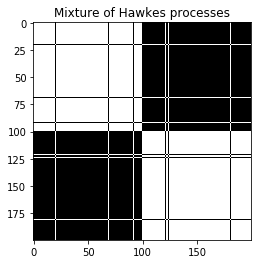

In [13]:
# 假设 model.R 是一个 NumPy 数组
labels1 = np.argmax(model['R'], axis=1)

# 估计相似性矩阵
Est1 = np.zeros((len(labels1), len(labels1)), dtype=int)
for i in range(len(labels1)):
    for j in range(len(labels1)):
        if labels1[i] == labels1[j]:
            Est1[i, j] = 1
plt.figure()
plt.imshow(Est1, cmap='gray', interpolation='none')
plt.title('Mixture of Hawkes processes')
plt.show()

NameError: name 'SimilarMat' is not defined

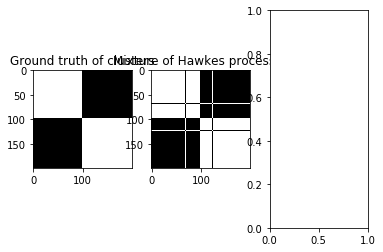

In [15]:
# #5. 结果可视化:
# 使用图形来显示真实聚类情况、霍克斯过程混合模型的估计结果，以及基于标记点过程的距离度量的估计结果。

# Visualize clustering results
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(GT, cmap='gray', interpolation='none')
plt.title('Ground truth of clusters')
plt.subplot(1, 3, 2)
plt.imshow(Est1, cmap='gray', interpolation='none')
plt.title('Mixture of Hawkes processes')
plt.subplot(1, 3, 3)
plt.imshow(SimilarMat, cmap='gray', interpolation='none')
plt.title('Distance metrics of MPP')
plt.show()